In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
import warnings
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

from sklearn import metrics
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline


In [ ]:
# Load csv file
df = pd.read_csv('backorder.csv', na_values="na")

In [ ]:
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62,NaN,0,0,0,0,0,0,0,...,0,-99.00,-99.00,0,Yes,No,No,Yes,No,No
1,3285131,9,NaN,0,0,0,0,0,0,0,...,0,-99.00,-99.00,0,No,No,Yes,No,No,No
2,3285358,17,8.0,0,0,0,0,0,0,0,...,0,0.92,0.95,0,No,No,No,Yes,No,No
3,3285517,9,2.0,0,0,0,0,0,0,0,...,0,0.78,0.75,0,No,No,Yes,Yes,No,No
4,3285608,2,8.0,0,0,0,0,0,0,0,...,0,0.54,0.71,0,No,No,No,Yes,No,No


In [ ]:
df.shape

(242075, 23)

In [ ]:
df['went_on_backorder'].value_counts()

No     239387
Yes      2688
Name: went_on_backorder, dtype: int64

In [ ]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 16 numerical features : ['sku', 'national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']

We have 7 categorical features : ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


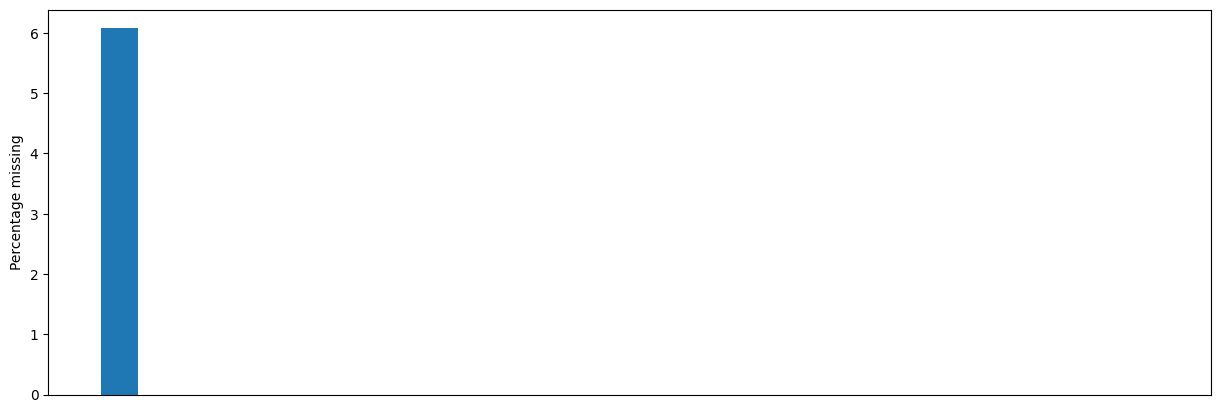

In [ ]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [ ]:
## Dropping columns which has more than 70% of missing values
dropcols = missing[missing[0]>70]
dropcols

,0


In [ ]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [ ]:
# Check shape of the dataset after dropping columns
df.shape

(242075, 23)

In [ ]:
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 0.2644527163248903%


Positive: 0, Negative: 0


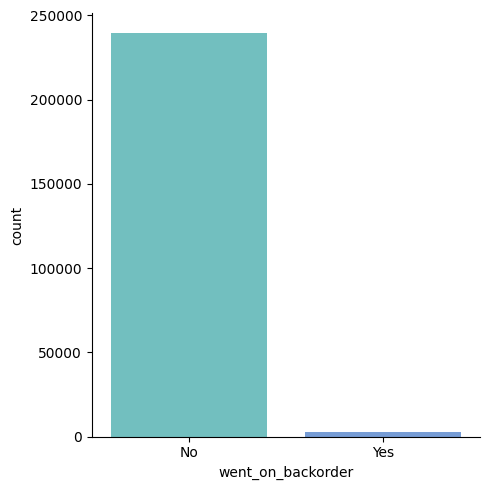

In [ ]:
pos = df[df['went_on_backorder']=='pos'].shape[0]
neg = df[df['went_on_backorder']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="went_on_backorder", kind="count", palette="winter_r", alpha=.6)
plt.show()

In [ ]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [ ]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification

    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [ ]:
# Create a function which can evaluate models and return a report
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    cost_list=[]
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')

    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])

    return report

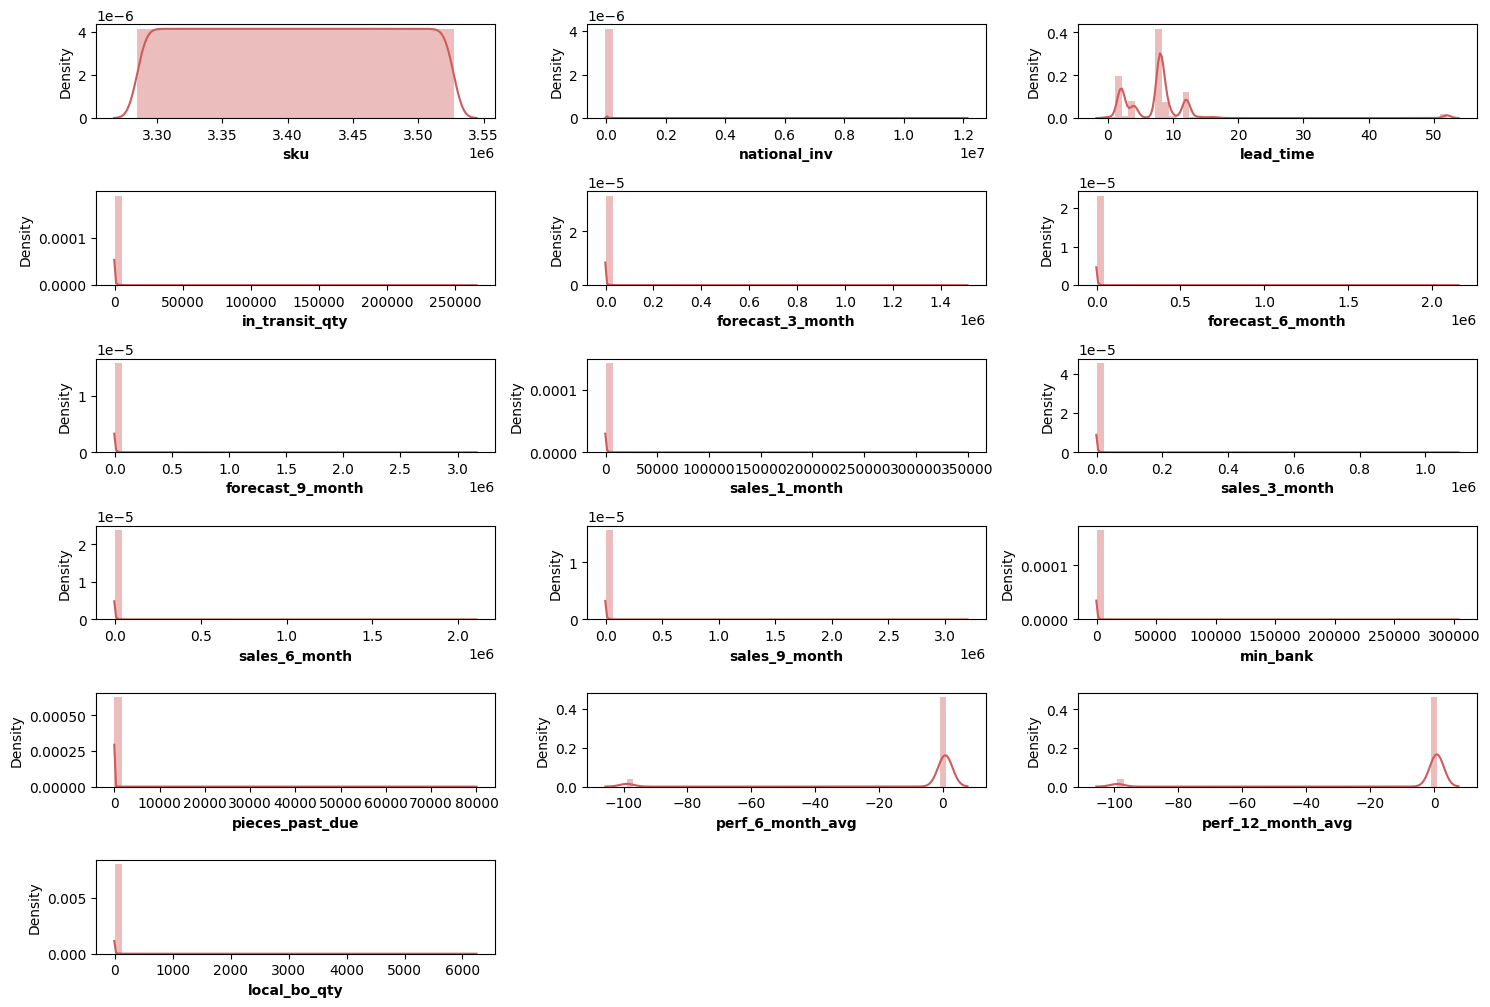

In [ ]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [ ]:
df["went_on_backorder"] = df["went_on_backorder"].fillna(df["went_on_backorder"].mode()[0])

In [ ]:
df['sku'] = df['sku'].astype(int)

In [ ]:
# Splitting X and y for all Experiments
X = df.drop('went_on_backorder', axis=1)
y = df['went_on_backorder']

In [ ]:
X = X.replace({'Yes':1, 'No':0})

In [ ]:
y= y.replace({'Yes': 1, 'No': 0})

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242075 entries, 0 to 242074
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sku                242075 non-null  int64  
 1   national_inv       242075 non-null  int64  
 2   lead_time          227351 non-null  float64
 3   in_transit_qty     242075 non-null  int64  
 4   forecast_3_month   242075 non-null  int64  
 5   forecast_6_month   242075 non-null  int64  
 6   forecast_9_month   242075 non-null  int64  
 7   sales_1_month      242075 non-null  int64  
 8   sales_3_month      242075 non-null  int64  
 9   sales_6_month      242075 non-null  int64  
 10  sales_9_month      242075 non-null  int64  
 11  min_bank           242075 non-null  int64  
 12  potential_issue    242075 non-null  int64  
 13  pieces_past_due    242075 non-null  int64  
 14  perf_6_month_avg   242075 non-null  float64
 15  perf_12_month_avg  242075 non-null  float64
 16  lo

In [ ]:
# Fit with robust scaler for KNN best K-selection experminet
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

In [ ]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.9886)
n_neighbors= 3 || accuracy (0.9887)
n_neighbors= 5 || accuracy (0.9887)
n_neighbors= 7 || accuracy (0.9886)
n_neighbors= 9 || accuracy (0.9886)


In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_knn =knn_pipeline.fit_transform(X)

In [ ]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

In [ ]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [ ]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9942
- F1 score: 0.9942
- Precision: 0.9933
- Recall: 0.9952
- Roc Auc Score: 0.9942
- COST: 118700.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9853
- F1 score: 0.9853
- Precision: 0.9820
- Recall: 0.9886
- Roc Auc Score: 0.9853
- COST: 281160.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9371
- F1 score: 0.9378
- Precision: 0.9279
- Recall: 0.9480
- Roc Auc Score: 0.9371
- COST: 5125100.
----------------------------------
Model performance for Test set
- Accuracy: 0.9382
- F1 score: 0.9387
- Precision: 0.9290
- Recall: 0.9487
- Roc 

In [ ]:
report_knn

,Model Name,Cost
4,K-Neighbors Classifier,60310
0,Random Forest,118700
6,CatBoosting Classifier,224490
5,XGBClassifier,264450
1,Decision Tree,281160
2,Gradient Boosting,1260150
3,Logistic Regression,1407020
7,AdaBoost Classifier,2128040


In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [ ]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9935
- F1 score: 0.9935
- Precision: 0.9925
- Recall: 0.9945
- Roc Auc Score: 0.9935
- COST: 134610.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9845
- F1 score: 0.9846
- Precision: 0.9814
- Recall: 0.9879
- Roc Auc Score: 0.9845
- COST: 299970.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9356
- F1 score: 0.9363
- Precision: 0.9259
- Recall: 0.9470
- Roc Auc Score: 0.9357
- COST: 5212890.
----------------------------------
Model performance for Test set
- Accuracy: 0.9359
- F1 score: 0.9368
- Precision: 0.9259
- Recall: 0.9479
- Roc 

In [ ]:
report_median

,Model Name,Cost
4,K-Neighbors Classifier,78230
0,Random Forest,134610
6,CatBoosting Classifier,230020
5,XGBClassifier,285910
1,Decision Tree,299970
2,Gradient Boosting,1285340
3,Logistic Regression,1965250
7,AdaBoost Classifier,2111610


In [ ]:
!pip install miceforest
import miceforest as mf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00


In [ ]:
X_mice = X.copy()
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [ ]:
X_mice = kernel.complete_data()

In [ ]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with Mice imputer
X_mice= mice_pipeline.fit_transform(X_mice)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [ ]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9936
- F1 score: 0.9937
- Precision: 0.9926
- Recall: 0.9947
- Roc Auc Score: 0.9936
- COST: 131030.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9842
- F1 score: 0.9842
- Precision: 0.9804
- Recall: 0.9880
- Roc Auc Score: 0.9842
- COST: 295930.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9367
- F1 score: 0.9375
- Precision: 0.9263
- Recall: 0.9490
- Roc Auc Score: 0.9368
- COST: 5020530.
----------------------------------
Model performance for Test set
- Accuracy: 0.9367
- F1 score: 0.9376
- Precision: 0.9246
- Recall: 0.9510
- Roc 

In [ ]:
report_mice

,Model Name,Cost
4,K-Neighbors Classifier,78630
0,Random Forest,131030
6,CatBoosting Classifier,227780
5,XGBClassifier,277050
1,Decision Tree,295930
2,Gradient Boosting,1209080
3,Logistic Regression,1677460
7,AdaBoost Classifier,1964850


In [ ]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_const =constant_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [ ]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9935
- F1 score: 0.9935
- Precision: 0.9926
- Recall: 0.9944
- Roc Auc Score: 0.9935
- COST: 137060.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9842
- F1 score: 0.9843
- Precision: 0.9806
- Recall: 0.9880
- Roc Auc Score: 0.9842
- COST: 296850.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9367
- F1 score: 0.9375
- Precision: 0.9263
- Recall: 0.9490
- Roc Auc Score: 0.9368
- COST: 5020530.
----------------------------------
Model performance for Test set
- Accuracy: 0.9367
- F1 score: 0.9376
- Precision: 0.9246
- Recall: 0.9510
- Roc 

In [ ]:
report_const

,Model Name,Cost
4,K-Neighbors Classifier,78630
0,Random Forest,137060
6,CatBoosting Classifier,227780
5,XGBClassifier,277050
1,Decision Tree,296850
2,Gradient Boosting,1209080
3,Logistic Regression,1677460
7,AdaBoost Classifier,1964850


In [ ]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_mean = mean_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

In [ ]:
# Training all models
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9935
- F1 score: 0.9935
- Precision: 0.9926
- Recall: 0.9944
- Roc Auc Score: 0.9935
- COST: 137050.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9847
- F1 score: 0.9848
- Precision: 0.9813
- Recall: 0.9882
- Roc Auc Score: 0.9847
- COST: 291020.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9363
- F1 score: 0.9369
- Precision: 0.9269
- Recall: 0.9472
- Roc Auc Score: 0.9363
- COST: 5189920.
----------------------------------
Model performance for Test set
- Accuracy: 0.9368
- F1 score: 0.9376
- Precision: 0.9270
- Recall: 0.9484
- Ro

In [ ]:
report_mean

,Model Name,Cost
4,K-Neighbors Classifier,75360
0,Random Forest,137050
6,CatBoosting Classifier,236140
5,XGBClassifier,285680
1,Decision Tree,291020
2,Gradient Boosting,1271280
3,Logistic Regression,1887730
7,AdaBoost Classifier,1940490


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_pca = pca_pipeline.fit_transform(X)

In [ ]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,23):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

<Axes: >

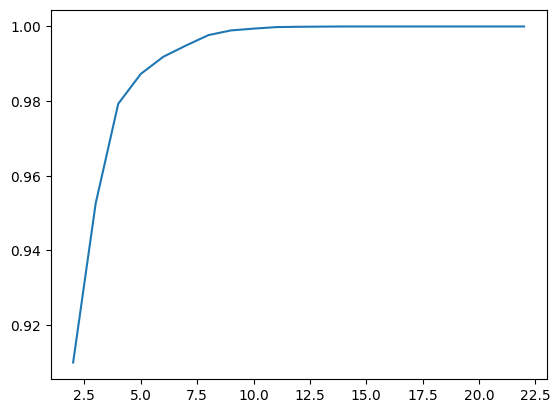

In [ ]:
# plotting variance ratio
pd.Series(var_ratio).plot()

In [ ]:
!pip install kneed

<Figure size 500x500 with 0 Axes>

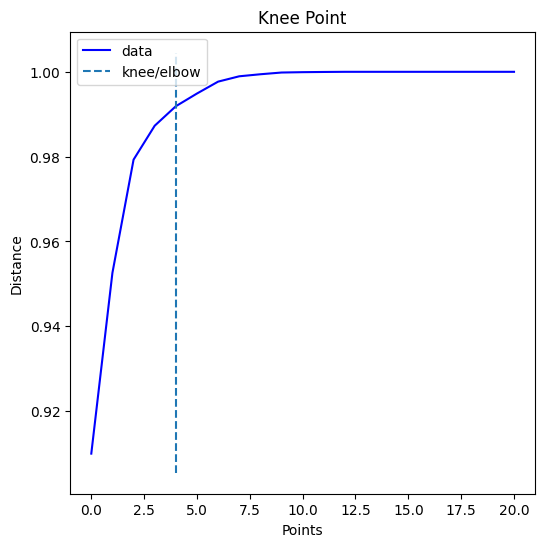

Knee Locator k = 6


In [ ]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [ ]:
# Reducing the dimensions of the data
pca_final=PCA(n_components=6,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

In [ ]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9994
- F1 score: 0.9994
- Precision: 0.9993
- Recall: 0.9995
- Roc Auc Score: 0.9994
- COST: 44370.
----------------------------------
Model performance for Test set
- Accuracy: 0.9727
- F1 score: 0.9731
- Precision: 0.9587
- Recall: 0.9880
- Roc Auc Score: 0.9727
- COST: 307340.


Decision Tree
Model performance for Training set
- Accuracy: 0.9994
- F1 score: 0.9994
- Precision: 0.9993
- Recall: 0.9996
- Roc Auc Score: 0.9994
- COST: 41420.
----------------------------------
Model performance for Test set
- Accuracy: 0.9550
- F1 score: 0.9554
- Precision: 0.9466
- Recall: 0.9644
- Roc Auc Score: 0.9549
- COST: 876490.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8397
- F1 score: 0.8455
- Precision: 0.8158
- Recall: 0.8776
- Roc Auc Score: 0.8397
- COST: 12065250.
----------------------------------
Model performance for Test set
- Accuracy: 0.8378
- F1 score: 0.8440
- Precision: 0.8136
- Recall: 0.87

In [ ]:
report_pca

,Model Name,Cost
4,K-Neighbors Classifier,283290
0,Random Forest,307340
1,Decision Tree,876490
6,CatBoosting Classifier,1227320
5,XGBClassifier,1284280
3,Logistic Regression,1980370
2,Gradient Boosting,3037970
7,AdaBoost Classifier,4466740


In [ ]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["KNN","Simple Imputer-Constant","78630"])
pt.add_row(["KNN","Mice","72650"])
pt.add_row(["KNN","Knn-Imputer","60310"])
pt.add_row(["KNN","Simple Imputer-Mean","75360"])
pt.add_row(["KNN","Median","78230"])
pt.add_row(["KNN","PCA","71680"])
print(pt)

+-------+-------------------------+------------+
| Model |    Imputation_method    | Total_cost |
+-------+-------------------------+------------+
|  KNN  | Simple Imputer-Constant |   78630    |
|  KNN  |           Mice          |   72650    |
|  KNN  |       Knn-Imputer       |   60310    |
|  KNN  |   Simple Imputer-Mean   |   75360    |
|  KNN  |          Median         |   78230    |
|  KNN  |           PCA           |   71680    |
+-------+-------------------------+------------+


In [ ]:
final_model = KNeighborsClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [ ]:
print("Final KNeighbors Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final KNeighbors Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final KNeighbors Classifier Accuracy Score (Train) : 0.9724264801952515
Final KNeighbors Classifier Accuracy Score (Test) : 0.9623714357387742


In [ ]:
print("Final KNeighbors Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final KNeighbors Classifier Cost Metric(Test) : 78630


In [ ]:
pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from sklearn.metrics import confusion_matrix

#plots Confusion matrix
confusion_matrix(y_test, y_pred)

array([[44316,  3513],
       [   87, 47756]])